In [1]:
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 8.0)
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import random

from numpy import arange
import bisect

Populating the interactive namespace from numpy and matplotlib


### Generate Bound Walk Examples

In this section, we will generate our random walk examples.

In order to obtain statistically reliable, results, 100 training sets, each consisting of 10 sequences, were constructed for use by all learning procedures.

In [70]:
def generateBoundedWalk():
    ret = ""
    d = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G'}
    state = 3
    ret += d[state]
    count = 1
    while((d[state] is not 'A') and(d[state] is not 'G')):
        flip = random.randint(0, 1)
        if(flip == 0):
            state += -1
            ret += d[state]
            count = count + 1
        else:
            state += 1
            ret += d[state]
            count = count + 1
    if((ret[-1] == 'A') or (ret[-1] == 'G')):
        return ret
    
    return ""
          
    
    

In [71]:
def generateBoundedWalks(size_of_set = 10):
    ret = []
    while(len(ret) < size_of_set):
        walk = generateBoundedWalk()
        if(len(walk) == 10):
            ret.append(walk)
     
    return(ret)
        

In [72]:
def generateSetsofBoundedWalks(number_of_sets = 100, size_of_set = 10):
    ret = []
    while(len(ret) < number_of_sets):
        st = generateBoundedWalks(size_of_set)
        ret.append(st)
    
    return ret
        

In [73]:
walks = generateBoundedWalks()
print(len(walks))
for item in walks:
    print(item)

10
DEDEDCDEFG
DEDCDEDCBA
DCDCBCDEFG
DEDEFEDEFG
DEDEFEDEFG
DCDCDCDCBA
DEDEFEDCBA
DEDEDEDEFG
DEDCBCDEFG
DCDEDEDEFG


### Implement TD Lambda algorithm

In this section, we will implement TD lambda.

In [74]:
def convertAlphaStateToVector(state):
    #d = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G'}
    switcher = {
        'A': np.array([0.]),
        'B': np.array([1.,0.,0.,0.,0.]),
        'C': np.array([0.,1.,0.,0.,0.]),
        'D': np.array([0.,0.,1.,0.,0.]),
        'E': np.array([0.,0.,0.,1.,0.]),
        'F': np.array([0.,0.,0.,0.,1.]),
        'G': np.array([1.]),
    }
    # Get the function from switcher dictionary
    func = switcher[state]
    # Execute the function
    return func

def convertAlphaSeqToVectorSeq(walk):
    ret = []
    for i in range(len(walk)):
        ret.append(convertAlphaStateToVector(walk[i]))
        
    #print(ret)
    return ret

In [75]:
def prediction(w, x):
    if((x == np.array([1.])).all()):
        #print('G')
        return 1
    if((x == np.array([0.])).all()):
        #print('A')
        return 0
    return w.T.dot(x)

def gradient(w, P, x):
    return x


def cal_delta_w(X, t, w_t, alpha, vlambda):    
        P_t = prediction(w_t, X[t-1]) #t -1 is t, array nonsense
        P_t_1 = prediction(w_t, X[t])   # t is t+1, in the array
        pred = (P_t_1 - P_t)
        sum_w = np.array([0.,0.,0.,0.,0.])
        for k in range(1, t+1):
            cal_lambda = pow(vlambda, t-k)
            g = gradient(w_t, P_t, X[k-1]) #k -1 is k, array nonsense
            sum_w += cal_lambda * g
            
        return(alpha*pred*sum_w)

def td_lambda(w, X, alpha, vlambda): 
    delta_w = np.array([0.,0.,0.,0,0.])
    for t in range(1,len(X)):
        tmp = cal_delta_w(X, t, w, alpha, vlambda)
        delta_w += tmp
        #w = w + delta_w
    ret = w + delta_w
    return ret


def td_lambda_ex1(w, X, alpha, vlambda): 
    delta_w = np.array([0.,0.,0.,0,0.])
    for t in range(1,len(X)):
        tmp = cal_delta_w(X, t, w, alpha, vlambda)         
        delta_w += tmp
        
    return delta_w

def td_lambda_ex2(w, X, alpha, vlambda): 
    delta_w = np.array([0.,0.,0.,0,0.])
    for t in range(1,len(X)):
        tmp = cal_delta_w(X, t, w, alpha, vlambda)
        delta_w += tmp
        #w = w + delta_w
    ret = w + delta_w
    return ret


## Experiment 1

### Figure 3
Average error on the random-walk problem under repeated presentations.
All data are from TD(A) with different values of A. The dependent measure
used is the RMS error between the ideal predictions and those found by the
learning procedure after being repeatedly presented with the training set
until convergence of the weight vector. This measure was averaged over
100 training sets to produce the data shown. The A = 1 data point is
the performance level attained by the Widrow-Hoff procedure. For each
data point, the standard error is approximately ~ = 0.01, so the differences
between the Widrow-Hoff procedure and the other procedures are highly
significant.



In [76]:
walks = generateSetsofBoundedWalks()

In [46]:
print(np.random.rand(5,))

[ 0.1924677   0.67403831  0.78894432  0.05759048  0.37275416]


In [60]:
def isConvergence(w1, w2, count):
    if(count > 100):
        return False
    else:
        RMSE = mean_squared_error(w1, w2)**0.5
        #print("{0}".format(RMSE))
        if(RMSE < 0.01):
            #print("{0}".format(RMSE))
            return False
        return True

In [64]:
def exp_1():
    actual = [1./6., 1./3., 1./2., 2./3., 5./6.]
    #w = np.array([0.5,0.5,0.5,0.5,0.5])
    w = np.random.rand(5,)
    lambdas = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.]
    alpha = 0.01
    #training_sets = generateSetsofBoundedWalks()
    training_sets = walks  
    ret = []
    for lambda_e in lambdas:
        cal = []
        for train in  training_sets: 
            w_e = w
            delta_w = np.array([0.,0.,0.,0,0.])
            w1 = w_e
            w2 = delta_w
            count = 0
            while(isConvergence(w1, w2, count)):
                w1 = w_e
                #print("HEERE")
                #rint(train)
                dw = []
                for seqence in train:
                    X = convertAlphaSeqToVectorSeq(seqence)
                    delta_w = td_lambda_ex1(w1, X, alpha,lambda_e)                 
                    w_e = w_e + delta_w   #print(delta_w)        
                w2 = w_e
                
                count = count + 1
            RMSE = mean_squared_error(actual, w_e)**0.5
            cal.append(RMSE)
        
        cal = np.array(cal)
        print("Lambda: {0}, avg: {1}, std:{2}".format(lambda_e, np.average(cal), np.std(cal)))
        ret.append((lambda_e, np.average(cal)))
    return ret

v = exp_1()

print(v)

Lambda: 0.0, avg: 0.14790596765439903, std:0.02155353859844532
Lambda: 0.1, avg: 0.1431313820889283, std:0.023772887274913872
Lambda: 0.2, avg: 0.1380985246847588, std:0.026482306463359997
Lambda: 0.3, avg: 0.13353852608832842, std:0.029275907741720307
Lambda: 0.4, avg: 0.12988498702874907, std:0.03276025210975505
Lambda: 0.5, avg: 0.12755766472447147, std:0.03737253064532188
Lambda: 0.6, avg: 0.12686808641444322, std:0.042486970748134276
Lambda: 0.7, avg: 0.12867107609006587, std:0.04817388566098725
Lambda: 0.8, avg: 0.13441665196873567, std:0.055505158930919805
Lambda: 0.9, avg: 0.14754128074580658, std:0.06532011145785817
Lambda: 1.0, avg: 0.17895435029318793, std:0.08117969111838859
[(0.0, 0.14790596765439903), (0.1, 0.14313138208892831), (0.2, 0.13809852468475881), (0.3, 0.13353852608832842), (0.4, 0.12988498702874907), (0.5, 0.12755766472447147), (0.6, 0.12686808641444322), (0.7, 0.12867107609006587), (0.8, 0.13441665196873567), (0.9, 0.14754128074580658), (1.0, 0.178954350293187

[(0.0, 0.14790596765439903), (0.1, 0.14313138208892831), (0.2, 0.13809852468475881), (0.3, 0.13353852608832842), (0.4, 0.12988498702874907), (0.5, 0.12755766472447147), (0.6, 0.12686808641444322), (0.7, 0.12867107609006587), (0.8, 0.13441665196873567), (0.9, 0.14754128074580658), (1.0, 0.17895435029318793)]
(0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)


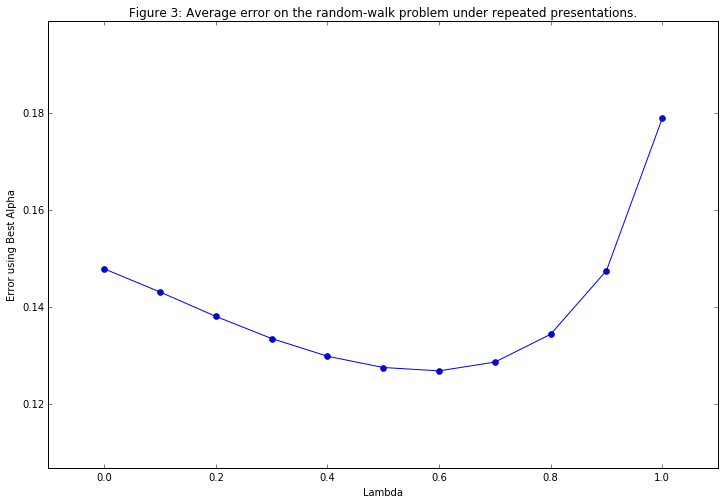

In [65]:
def figure3_plot_1(x,y, ext_x = 0.1, ext_y = 0.02):
    fig = plt.figure()
    #fig.suptitle('Figure 3', fontsize=14, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.set_title('Figure 3: Average error on the random-walk problem under repeated presentations.')

    ax.set_xlabel('Lambda')
    ax.set_ylabel('Error using Best Alpha')

    
    ax.plot(x,y,marker='o')
    plt.xlim(min(x)-ext_x,max(x)+ext_x)
    plt.ylim(min(y)-ext_y,max(y)+ext_y)
    plt.show()
    
    
print(v)    
x,y = zip(*v)
print(x)
figure3_plot_1(x, y)

## Experiment 2

The second experiment concerns the question of learning rate when the
training set is presented just once rather than repeatedly until convergence.
Although it is difficult to prove a theorem concerning learning rate, it is easy to
perform the relevant computational experiment. We presented the same data
to the learning procedures, again for several values of lambda, with the following
procedural changes. First, each training set was presented once to each procedure.
Second, weight updates were performed after each sequence, as in (1),
rather than after each complete training set. Third, each learning procedure
was applied with a range of values for the learning-rate parameter a. Fourth,
so that there was no bias either toward right-side or left-side terminations, all
components of the weight vector were initially set to 0.5.


### Figure 4
Average error on random walk problem after experiencing 10 sequences.
All data are from TD(lambda) with different values of alpha and Lambda. The dependent
measure is the RMS error between the ideal predictions and those found
by the learning procedure after a single presentation of a training set.
This measure was averaged over 10O training sets. The lamba = 1 data points
represent performances of the Widrow-Hoff supervised-learning procedure.

### Figure 5
Average error at best Alpha value on random-walk problem. Each data point
represents the average over 100 training sets of the error in the estimates
found by TD(Lambda)~), for particular A and a values, after a single presentation
of a training set. The Lambda value is given by the horizontal coordinate. The alpha
value was selected from those shown in Figure 4 to yield the lowest error
for that lambda, value.


In [66]:
walks = walks  

### Figure 4

In [77]:
def exp_2():
    actual = [1./6., 1./3., 1./2., 2./3., 5./6.]
    w = np.array([0.5,0.5,0.5,0.5,0.5])
    #lambdas = [0., 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
    lambdas = [0.0]
    alpha = 0.60
    training_sets = walks  
    ret = []
    
    for lambda_e in lambdas:
        cal = []     
        for train in  training_sets:             
            w_e = w
            for sequence in train:
                X = convertAlphaSeqToVectorSeq(sequence)
                #print(sequence)
                w_e = td_lambda_ex2(w_e, X, alpha, lambda_e)
            #print(w_e)
            RMSE = mean_squared_error(actual, w_e)**0.5
            cal.append(RMSE)     
        cal = np.array(cal)
        print("Lambda: {0}, avg: {1}, std:{2}".format(lambda_e, np.average(cal), np.std(cal)))
        ret.append((lambda_e, np.average(cal)))
    return ret

g = exp_2()

print(g)

Lambda: 0.0, avg: 5.845480899444359, std:9.707668629962217
[(0.0, 5.8454808994443592)]


In [78]:
def exp_2_4():
    actual = [1./6., 1./3., 1./2., 2./3., 5./6.]
    w = np.array([0.5,0.5,0.5,0.5,0.5])
    lambdas = [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    #alpha = 0.10
    alphas = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
    #training_sets = generateSetsofBoundedWalks()
    training_sets = walks  
    ret = []
    for lambda_e in lambdas:
        alp_arr = []
        for alpha in alphas:
            cal = []
            for train in  training_sets: 
                w_e = w
                for seqence in train:
                    #print(seqence)
                    X = convertAlphaSeqToVectorSeq(seqence)
                    #print(X[-1])               
                    w_e = td_lambda_ex2(w_e, X, alpha,lambda_e)

                RMSE = mean_squared_error(actual, w_e)**0.5
                cal.append(RMSE)

            cal = np.array(cal)
            print("Lambda: {0}, alpha:{1}, avg: {2}, std:{3}".format(lambda_e, alpha, np.average(cal), np.std(cal)))
            avg = np.average(cal)
            alp_arr.append((alpha, avg  if avg < 1.0 else np.nan))
        
        ret.append((lambda_e, alp_arr))
        
        #ret.append((lambda_e, np.average(cal)))
            
    return ret

v = exp_2_4()

#print(v)

Lambda: 0.0, alpha:0.0, avg: 0.23570226039551584, std:0.0
Lambda: 0.0, alpha:0.05, avg: 0.1745416402187282, std:0.0016590531814000872
Lambda: 0.0, alpha:0.1, avg: 0.12949453298090613, std:0.005877659747091965
Lambda: 0.0, alpha:0.15, avg: 0.0997320833383856, std:0.01264588324818802
Lambda: 0.0, alpha:0.2, avg: 0.08477501607728533, std:0.020861950339101328
Lambda: 0.0, alpha:0.25, avg: 0.08286974481374415, std:0.02903946674814081
Lambda: 0.0, alpha:0.3, avg: 0.09133585009007017, std:0.03738688240257609
Lambda: 0.0, alpha:0.35, avg: 0.11019892335651559, std:0.049828720354707944
Lambda: 0.0, alpha:0.4, avg: 0.15358406451920473, std:0.08202690692613797
Lambda: 0.0, alpha:0.45, avg: 0.28030608383948996, std:0.25315855724200365
Lambda: 0.0, alpha:0.5, avg: 0.7162517186368481, std:0.9435089360482354
Lambda: 0.0, alpha:0.55, avg: 2.0739372455624387, std:3.2067804719355886
Lambda: 0.0, alpha:0.6, avg: 5.845480899444359, std:9.707668629962217
Lambda: 0.1, alpha:0.0, avg: 0.23570226039551584, std

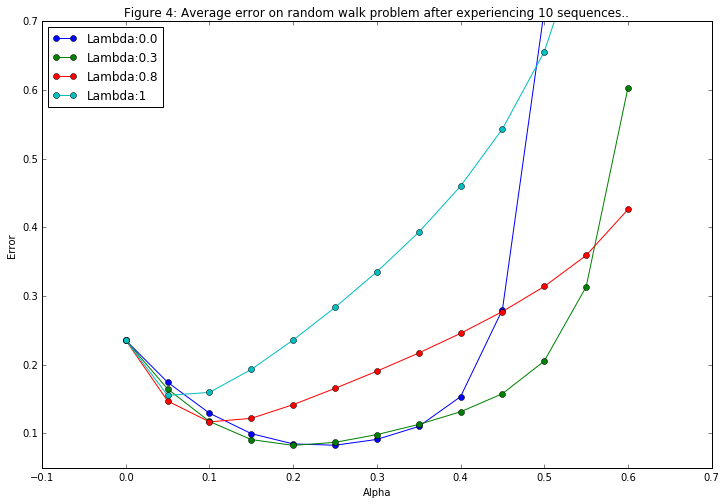

In [79]:
def figure4_plot_1(lambda_arr, tup, ext_x = 0.1, ext_y = 0.02):
    fig = plt.figure()
    #fig.suptitle('Figure 4', fontsize=14, fontweight='bold')
    
    
    for i in range(0,len(lambda_arr)):
        ax = fig.add_subplot(111)
        
        if(lambda_arr[i] in [1, 0.0, 0.8, 0.3]):
            #print(lambda_arr[i])
            x,y = zip(*tup[i])
            ax.set_xlabel('Alpha')
            ax.set_ylabel('Error')
            ax.plot(x,y,marker='o', label ='Lambda:{0}'.format(lambda_arr[i]))
            
    
    ax.set_title('Figure 4: Average error on random walk problem after experiencing 10 sequences..')
    plt.xlim(-0.1,0.7)
    plt.ylim(0.05,0.7)
    plt.legend(loc='upper left')
    plt.show()
    
    
#print(v)    
lambda_arr,tup = zip(*v)
#print(lambda_arr)
#print(tup)
x,y = zip(*tup[0])
#print(x)
#print(y)
figure4_plot_1(lambda_arr,tup)

### Figure 5

In [80]:
def getBestAlpha(lambda_arr, tup):
    ret = []
    for i in range(0, len(lambda_arr)):
        x,y = zip(*tup[i])
        y = np.array(y)
        y= y[numpy.logical_not(numpy.isnan(y))]
        index = np.argmin(y)
        ret.append((lambda_arr[i], x[index]))  
    return ret


lambda_arr,tup = zip(*v)
alphas = getBestAlpha(lambda_arr, tup)

print(alphas)

[(0.0, 0.25), (0.1, 0.25), (0.2, 0.2), (0.3, 0.2), (0.4, 0.2), (0.5, 0.15), (0.6, 0.15), (0.7, 0.15), (0.8, 0.1), (0.9, 0.1), (1, 0.05)]


In [81]:
def exp_2_5(alphas):
    actual = [1./6., 1./3., 1./2., 2./3., 5./6.]
    w = np.array([0.5,0.5,0.5,0.5,0.5])
   
    #training_sets = generateSetsofBoundedWalks()
    training_sets = walks  
    ret = []
    for lambda_e, alpha in alphas:
        cal = []
        for train in  training_sets: 
            w_e = w
            for seqence in train:
                #print(seqence)
                X = convertAlphaSeqToVectorSeq(seqence)
                #print(X[-1])
                w_e = td_lambda_ex2(w_e, X, alpha,lambda_e)

            RMSE = mean_squared_error(actual, w_e)**0.5
            cal.append(RMSE)
        
        cal = np.array(cal)
        print("Lambda: {0}, alpha:{1}, avg: {2}, std:{3}".format(lambda_e, alpha, np.average(cal), np.std(cal)))
        ret.append((lambda_e, np.average(cal)))
    return ret

k = exp_2_5(alphas)

print(k)

Lambda: 0.0, alpha:0.25, avg: 0.08286974481374415, std:0.02903946674814081
Lambda: 0.1, alpha:0.25, avg: 0.08258565720700135, std:0.03217079263371251
Lambda: 0.2, alpha:0.2, avg: 0.08214136263835665, std:0.02773411956675709
Lambda: 0.3, alpha:0.2, avg: 0.08263934826579851, std:0.03251687109846499
Lambda: 0.4, alpha:0.2, avg: 0.0851808785825747, std:0.03844609692598263
Lambda: 0.5, alpha:0.15, avg: 0.0906672311359965, std:0.032355715361883274
Lambda: 0.6, alpha:0.15, avg: 0.09485776142098004, std:0.0406471484270326
Lambda: 0.7, alpha:0.15, avg: 0.10449269561677689, std:0.05067670517509682
Lambda: 0.8, alpha:0.1, avg: 0.11685590458733999, std:0.042395267138049884
Lambda: 0.9, alpha:0.1, avg: 0.1321927089754261, std:0.0560669284309744
Lambda: 1, alpha:0.05, avg: 0.15543813600346051, std:0.04100419156583138
[(0.0, 0.082869744813744151), (0.1, 0.082585657207001353), (0.2, 0.082141362638356655), (0.3, 0.08263934826579851), (0.4, 0.085180878582574698), (0.5, 0.090667231135996507), (0.6, 0.094

[(0.0, 0.082869744813744151), (0.1, 0.082585657207001353), (0.2, 0.082141362638356655), (0.3, 0.08263934826579851), (0.4, 0.085180878582574698), (0.5, 0.090667231135996507), (0.6, 0.094857761420980041), (0.7, 0.10449269561677689), (0.8, 0.11685590458733999), (0.9, 0.13219270897542609), (1, 0.15543813600346051)]
(0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1)


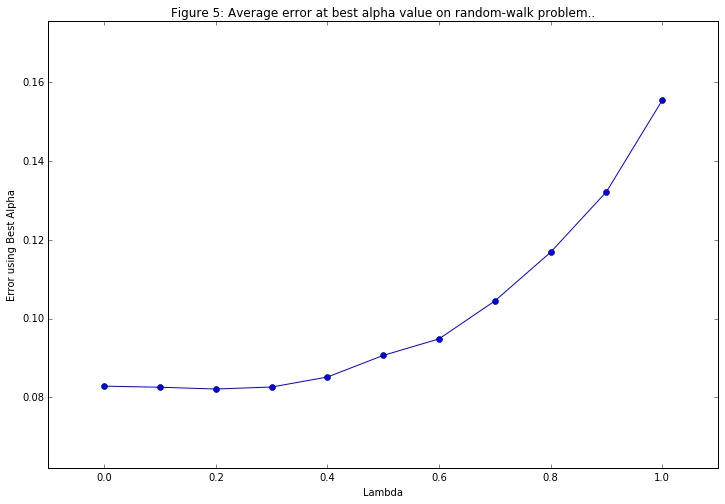

In [82]:
def figure5_plot_1(x,y, ext_x = 0.1, ext_y = 0.02):
    fig = plt.figure()
    #fig.suptitle('Figure 5', fontsize=14, fontweight='bold')
    ax = fig.add_subplot(111)
    ax.set_title('Figure 5: Average error at best alpha value on random-walk problem..')

    ax.set_xlabel('Lambda')
    ax.set_ylabel('Error using Best Alpha')

    
    ax.plot(x,y,marker='o')
    plt.xlim(min(x)-ext_x,max(x)+ext_x)
    plt.ylim(min(y)-ext_y,max(y)+ext_y)
    plt.show()
    
    
print(k)    
x,y = zip(*k)
print(x)
figure5_plot_1(x, y)